# Synthetic Trajectory Generation with Nomad

This notebook demonstrates how to generate realistic synthetic human mobility trajectories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
from joblib import Parallel, delayed

from nomad.city_gen import City
from nomad.traj_gen import Agent, Population
from nomad.stop_detection.viz import plot_pings, plot_time_barcode

In [3]:
city = City.from_geopackage('garden-city.gpkg')
city._build_hub_network(hub_size=16)
city.compute_gravity(exponent=2.0)
city.compute_shortest_paths(callable_only=True)

print(f"City: {city.name}")
print(f"Dimensions: {city.dimensions}")
print(f"Buildings: {len(city.buildings_gdf)}")

City: Garden City
Dimensions: (22, 22)
Buildings: 106


## Part 1: Effect of Sampling Parameters on Sparsity

Generate 3 agents with 2-day trajectories, varying beta_duration and beta_start 
to show their effect on sparsity (q = observed points / ground truth points).

In [4]:
population = Population(city)
population.generate_agents(N=3, seed=42, name_count=2)

# Vary beta_duration and beta_start to target different sparsity levels
sampling_params = [
    {'beta_ping': 5, 'beta_start': 100, 'beta_durations': 60},   
    {'beta_ping': 5, 'beta_start': 250, 'beta_durations': 150},  
    {'beta_ping': 5, 'beta_start': 400, 'beta_durations': 240}   
]

# Generate 2-day trajectories for quick visualization
for i, (agent_id, agent) in enumerate(population.roster.items()):
    agent.generate_trajectory(
        datetime=pd.Timestamp("2024-01-01T07:00-04:00"),
        end_time=pd.Timestamp("2024-01-03T07:00-04:00"),
        seed=i
    )

    agent.sample_trajectory(
        **sampling_params[i],
        replace_sparse_traj=True,
        seed=i
    )
    
    q = len(agent.sparse_traj) / len(agent.trajectory)
    print(f"Agent {i}: q={q:.3f}, beta_start={sampling_params[i]['beta_start']}, "
          f"beta_dur={sampling_params[i]['beta_durations']}")

Agent 0: q=0.051, beta_start=100, beta_dur=60
Agent 1: q=0.031, beta_start=250, beta_dur=150
Agent 2: q=0.135, beta_start=400, beta_dur=240


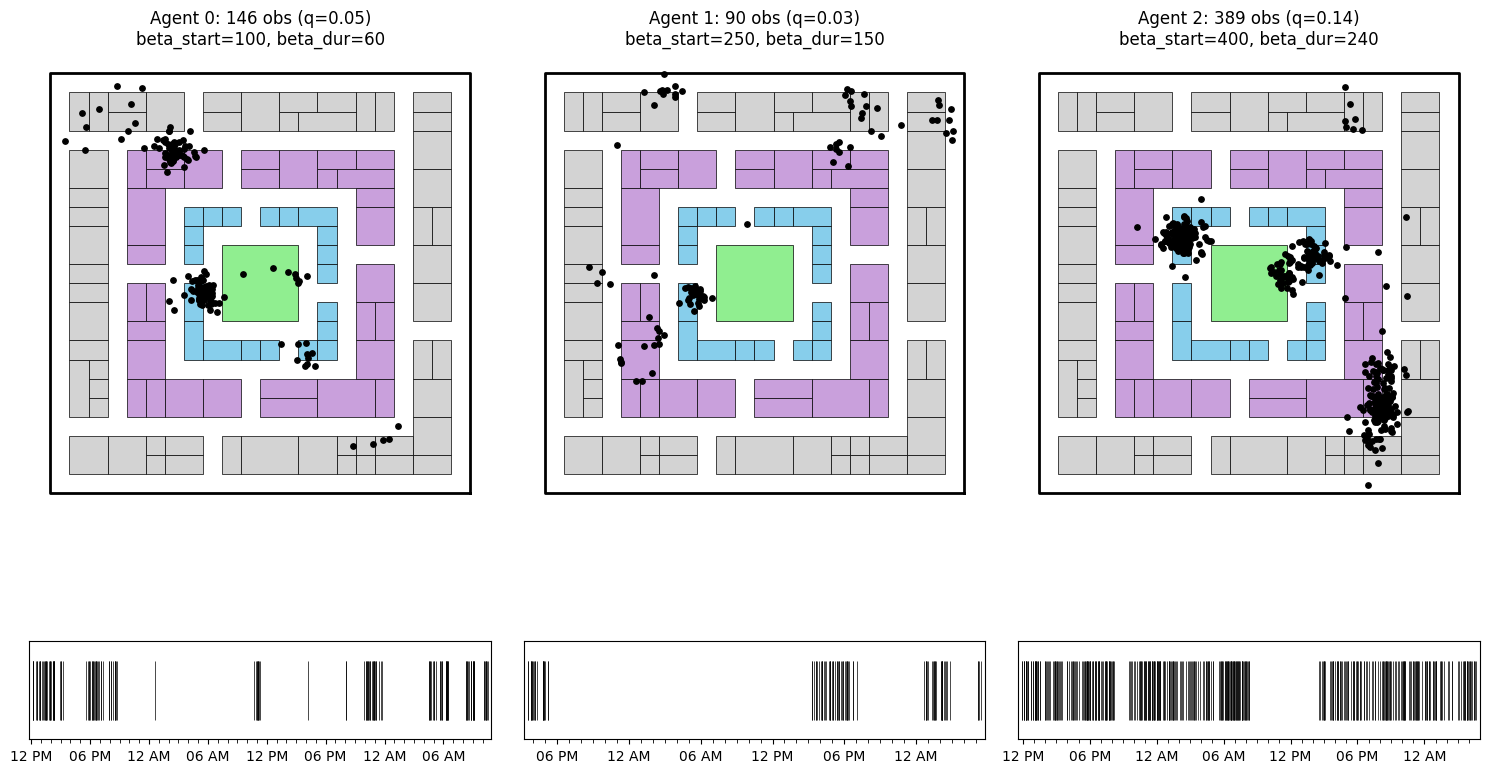

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), 
                         gridspec_kw={'height_ratios': [10, 1]})

for i, (agent_id, agent) in enumerate(population.roster.items()):
    ax_map = axes[0, i]
    ax_barcode = axes[1, i]
    
    city.plot_city(ax=ax_map, doors=False, address=False)
    
    traj = agent.sparse_traj
    plot_pings(traj, ax=ax_map, s=15, point_color='red', 
               x='x', y='y', timestamp='timestamp')
    
    plot_time_barcode(traj['timestamp'], ax=ax_barcode, set_xlim=True)
    
    q = len(traj) / len(agent.trajectory)
    ax_map.set_title(f"Agent {i}: {len(traj)} obs (q={q:.2f})\n"
                     f"beta_start={sampling_params[i]['beta_start']}, "
                     f"beta_dur={sampling_params[i]['beta_durations']}")
    ax_map.set_axis_off()

plt.tight_layout()
plt.savefig('data/trajectories_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## Part 2: Parallel Generation at Scale

Generate trajectories for 15 users using parallelization.

In [6]:
def generate_agent_trajectory(args):
    """Worker function for parallel generation."""
    identifier, home, work, seed = args
    city = City.from_geopackage('garden-city.gpkg')
    city._build_hub_network(hub_size=16)
    city.compute_gravity(exponent=2.0)
    city.compute_shortest_paths(callable_only=True)
    agent = Agent(identifier=identifier, city=city, home=home, workplace=work)
    
    agent.generate_trajectory(
        datetime=pd.Timestamp("2024-01-01T07:00-04:00"),
        end_time=pd.Timestamp("2024-01-08T07:00-04:00"),
        seed=seed
    )
    agent.sample_trajectory(
        beta_ping=5,
        replace_sparse_traj=True,
        seed=seed
    )
    sparse_df = agent.sparse_traj.copy()
    sparse_df['user_id'] = identifier
    sparse_df['home'] = home
    sparse_df['workplace'] = work
    return sparse_df

In [7]:
n_agents = 15
rng = np.random.default_rng(100)
homes = city.buildings_gdf[city.buildings_gdf['building_type'] == 'home']['id'].to_numpy()
workplaces = city.buildings_gdf[city.buildings_gdf['building_type'] == 'workplace']['id'].to_numpy()

agent_params = [
    (f'agent_{i:04d}',
     rng.choice(homes),
     rng.choice(workplaces),
     i)
    for i in range(n_agents)
]

In [8]:
print(f"Generating {n_agents} agents in parallel...")
start_time = time.time()

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(generate_agent_trajectory)(params) for params in agent_params
)

generation_time = time.time() - start_time
print(f"Generated {n_agents} agents in {generation_time:.2f}s ({generation_time/n_agents:.2f}s per agent)")

Generating 15 agents in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   18.3s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   23.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   24.6s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   24.9s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   27.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   29.2s remaining:    7.2s


Generated 15 agents in 30.52s (2.03s per agent)


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   30.4s finished


In [10]:
parallel_population = Population(city)
for df, params in zip(results, agent_params):
    identifier, home, work, seed = params
    agent = Agent(identifier=identifier, city=city, home=home, workplace=work, seed=seed)
    agent.sparse_traj = df.drop(columns=['home', 'workplace'])
    parallel_population.add_agent(agent, verbose=False)

output_path = 'data/trajectories_15_users'
parallel_population.save_pop(
    sparse_path=str(output_path),
    fmt='parquet'
)
print(f"Saved sparse trajectories to {output_path}")

Saved sparse trajectories to data/trajectories_15_users
